In [1]:
#import relevant libraries

#general
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#NLP
import nltk
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist, pos_tag

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet')

#machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier

#model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import silhouette_score

#preprocessing and pipleline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

#imbalanced data
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andrewreusche/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#pull in the data

In [3]:
df= pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='ISO-8859-1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
raw_df= df[['tweet_text','is_there_an_emotion_directed_at_a_brand_or_product']]
raw_df= raw_df.dropna()
raw_df = raw_df.drop_duplicates(keep='first')
raw_df = raw_df.rename(columns={'tweet_text': 'tweet', 
                                'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'})
raw_df['emotion'].value_counts(normalize= True)

emotion
No emotion toward brand or product    0.592613
Positive emotion                      0.327453
Negative emotion                      0.062734
I can't tell                          0.017200
Name: proportion, dtype: float64

In [6]:
rel_raw_df = raw_df[raw_df['emotion'] != "I can't tell"]
sentiment_map = {'No emotion toward brand or product': 0,
    'Positive emotion': 1,
    'Negative emotion': 0}
rel_raw_df['sentiment'] = rel_raw_df['emotion'].map(sentiment_map)
rel_raw_df['sentiment'].value_counts(normalize= True)

sentiment
0    0.666816
1    0.333184
Name: proportion, dtype: float64

In [126]:
rel_raw_df['tweet'][9088]

'ipad everywhere. {link}'

In [7]:

rel_raw_df["tweet"] = rel_raw_df["tweet"].str.lower()
rel_raw_df[:10]

,tweet,emotion,sentiment
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,Negative emotion,0
1,@jessedee know about @fludapp ? awesome ipad/i...,Positive emotion,1
2,@swonderlin can not wait for #ipad 2 also. the...,Positive emotion,1
3,@sxsw i hope this year's festival isn't as cra...,Negative emotion,0
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Positive emotion,1
5,@teachntech00 new ipad apps for #speechtherapy...,No emotion toward brand or product,0
7,"#sxsw is just starting, #ctia is around the co...",Positive emotion,1
8,beautifully smart and simple idea rt @madebyma...,Positive emotion,1
9,counting down the days to #sxsw plus strong ca...,Positive emotion,1
10,excited to meet the @samsungmobileus at #sxsw ...,Positive emotion,1


In [42]:
word_tokenize('hello i am justin')

['hello', 'i', 'am', 'justin']

In [107]:
#removing usernames
rel_raw_df["tweet"]= rel_raw_df["tweet"].apply(lambda x : ' '.join([w for w in x.split() if '@' not in w]).strip())
#drop instance 9092

In [96]:
rel_raw_df["tweet"].apply(lambda x : ' '.join([w for w in x.split() if '#' in w])).tolist()

['#rise_austin, #sxsw.',
 '#sxsw',
 '#ipad #sxsw.',
 '#sxsw',
 '#sxsw:',
 '#speechtherapy #sxsw #iear #edchat #asd',
 '#sxsw #ctia #googleio #android',
 '#hollergram #sxsw!',
 '#sxsw',
 '#sxsw #fail',
 '#sxsw',
 '#sxsw',
 '#sxsw',
 '#sxsw',
 '#hollergram #sxsw',
 '#sxsw',
 '#sxsw #iphone',
 '#sxsw',
 '#sxsw',
 '#sxsw.',
 '#sxsw',
 '#android #sxsw',
 '#sxsw',
 '#sxsw',
 '#smcdallas #sxsw #ipad #chevysmc',
 '#hollergram #sxsw',
 '#austin pre-#sxsw.',
 '#4sq3 #sxsw #keepaustinweird',
 '#android #sxsw',
 '#hollergram #sxsw!',
 '#sxsw #hollergram',
 '#sxsw #gdgtlive',
 '#sxsw',
 '#sxsw',
 '#sxsw.',
 '#ipad2 #sxsw #eventprofs #pcma #engage365',
 '#itunes #sxsw',
 '#google #circles #social #sxsw',
 '#sxsw',
 '#sxsw!',
 '#sxsw',
 '#sxsw #zazzlesxsw',
 '#ipad #sxsw #gadgets',
 '#ubersocial #iphone #sxsw',
 '#ipad2 \x89û÷#smartcover\x89ûª #apple #sxsw',
 '#sxsw',
 '#sxsw',
 '#circles #sxsw\x89û\x9d',
 '#sxsw\x89û\x9d',
 '#sxsw',
 '#libya #sxsw',
 '#edchat #musedchat #sxsw #sxswi #classical #newt

In [106]:
#removing hashtags
rel_raw_df["tweet"]= rel_raw_df["tweet"].apply(lambda x : ' '.join([w for w in x.split() if '#' not in w]))

In [105]:
#9092 is a nonsensical tweet
#rel_raw_df= rel_raw_df.drop(9092)
rel_raw_df

,tweet,emotion,sentiment,tweet_tokenized,tweet_tokenized_ns,tweet_lem
0,i have a 3g iphone. after 3 hrs tweeting at it...,Negative emotion,0,"[wesley, i, have, a, g, iphone, after, hrs, tw...","[wesley, g, iphone, hrs, tweeting, rise, austi...","[wesley, g, iphone, hr, tweeting, rise, austin..."
1,know about ? awesome ipad/iphone app that you'...,Positive emotion,1,"[jessedee, know, about, fludapp, awesome, ipad...","[jessedee, know, fludapp, awesome, ipad, iphon...","[jessedee, know, fludapp, awesome, ipad, iphon..."
2,can not wait for 2 also. they should sale them...,Positive emotion,1,"[swonderlin, can, not, wait, for, ipad, also, ...","[swonderlin, not, wait, ipad, also, sale, sxsw]","[swonderlin, not, wait, ipad, also, sale, sxsw]"
3,i hope this year's festival isn't as crashy as...,Negative emotion,0,"[sxsw, i, hope, this, years, festival, isnt, a...","[sxsw, hope, years, festival, isnt, crashy, ye...","[sxsw, hope, year, festival, isnt, crashy, yea..."
4,"great stuff on fri marissa mayer (google), tim...",Positive emotion,1,"[sxtxstate, great, stuff, on, fri, sxsw, maris...","[sxtxstate, great, stuff, fri, sxsw, marissa, ...","[sxtxstate, great, stuff, fri, sxsw, marissa, ..."
...,...,...,...,...,...,...
9087,"yup, but i don't have a third app yet. i'm on ...",No emotion toward brand or product,0,"[mention, yup, but, i, dont, have, a, third, a...","[mention, yup, dont, third, app, yet, im, andr...","[mention, yup, dont, third, app, yet, im, andr..."
9088,ipad everywhere. {link},Positive emotion,1,"[ipad, everywhere, sxsw, link]","[ipad, everywhere, sxsw, link]","[ipad, everywhere, sxsw, link]"
9089,"wave, buzz... rt we interrupt your regularly s...",No emotion toward brand or product,0,"[wave, buzz, rt, mention, we, interrupt, your,...","[wave, buzz, rt, mention, interrupt, regularly...","[wave, buzz, rt, mention, interrupt, regularly..."
9090,"google's zeiger, a physician never reported po...",No emotion toward brand or product,0,"[googles, zeiger, a, physician, never, reporte...","[googles, zeiger, physician, never, reported, ...","[google, zeiger, physician, never, reported, p..."


In [121]:
def strip_token(tweet):
    tweet = re.sub(r'http[s]?://\S+|www\.\S+', '', tweet)
    tweet = re.sub(r'&amp;', 'and', tweet)
    tweet = re.sub(r'/', ' ', tweet)
    tweet = re.sub(r'_', ' ', tweet)
    tweet = re.sub(r'\d+\w*', '', tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tweet = re.sub(r'can not', "cant", tweet)
    tweet = re.sub(r'will not', "wont", tweet)
    tokens = word_tokenize(tweet)
    return tokens

rel_raw_df['tweet_tokenized'] = rel_raw_df['tweet'].apply(strip_token)
rel_raw_df.head()

,tweet,emotion,sentiment,tweet_tokenized,tweet_tokenized_ns,tweet_lem
0,i have a 3g iphone. after 3 hrs tweeting at it...,Negative emotion,0,"[i, have, a, iphone, after, hrs, tweeting, at,...","[iphone, hrs, tweeting, dead, need, upgrade, p...","[iphone, hr, tweeting, dead, need, upgrade, pl..."
1,know about ? awesome ipad/iphone app that you'...,Positive emotion,1,"[know, about, awesome, ipad, iphone, app, that...","[know, awesome, ipad, iphone, app, youll, like...","[know, awesome, ipad, iphone, app, youll, like..."
2,can not wait for 2 also. they should sale them...,Positive emotion,1,"[cant, wait, for, also, they, should, sale, th...","[cant, wait, also, sale]","[cant, wait, also, sale]"
3,i hope this year's festival isn't as crashy as...,Negative emotion,0,"[i, hope, this, years, festival, isnt, as, cra...","[hope, years, festival, isnt, crashy, years, i...","[hope, year, festival, isnt, crashy, year, iph..."
4,"great stuff on fri marissa mayer (google), tim...",Positive emotion,1,"[great, stuff, on, fri, marissa, mayer, google...","[great, stuff, fri, marissa, mayer, google, ti...","[great, stuff, fri, marissa, mayer, google, ti..."


In [131]:
rel_raw_df['tweet_len']= rel_raw_df.tweet_tokenized.apply(lambda x : len(x))
rel_raw_df

,tweet,emotion,sentiment,tweet_tokenized,tweet_tokenized_ns,tweet_lem,tweet_len
0,i have a 3g iphone. after 3 hrs tweeting at it...,Negative emotion,0,"[i, have, a, iphone, after, hrs, tweeting, at,...","[iphone, hrs, tweeting, dead, need, upgrade, p...","[iphone, hr, tweeting, dead, need, upgrade, pl...",18
1,know about ? awesome ipad/iphone app that you'...,Positive emotion,1,"[know, about, awesome, ipad, iphone, app, that...","[know, awesome, ipad, iphone, app, youll, like...","[know, awesome, ipad, iphone, app, youll, like...",19
2,can not wait for 2 also. they should sale them...,Positive emotion,1,"[cant, wait, for, also, they, should, sale, th...","[cant, wait, also, sale]","[cant, wait, also, sale]",10
3,i hope this year's festival isn't as crashy as...,Negative emotion,0,"[i, hope, this, years, festival, isnt, as, cra...","[hope, years, festival, isnt, crashy, years, i...","[hope, year, festival, isnt, crashy, year, iph...",13
4,"great stuff on fri marissa mayer (google), tim...",Positive emotion,1,"[great, stuff, on, fri, marissa, mayer, google...","[great, stuff, fri, marissa, mayer, google, ti...","[great, stuff, fri, marissa, mayer, google, ti...",16
...,...,...,...,...,...,...,...
9087,"yup, but i don't have a third app yet. i'm on ...",No emotion toward brand or product,0,"[yup, but, i, dont, have, a, third, app, yet, ...","[yup, dont, third, app, yet, im, android, sugg...","[yup, dont, third, app, yet, im, android, sugg...",15
9088,ipad everywhere. {link},Positive emotion,1,"[ipad, everywhere, link]","[ipad, everywhere, link]","[ipad, everywhere, link]",3
9089,"wave, buzz... rt we interrupt your regularly s...",No emotion toward brand or product,0,"[wave, buzz, rt, we, interrupt, your, regularl...","[wave, buzz, rt, interrupt, regularly, schedul...","[wave, buzz, rt, interrupt, regularly, schedul...",14
9090,"google's zeiger, a physician never reported po...",No emotion toward brand or product,0,"[googles, zeiger, a, physician, never, reporte...","[googles, zeiger, physician, never, reported, ...","[google, zeiger, physician, never, reported, p...",18


In [133]:
rel_raw_df[rel_raw_df['tweet_len']<5]

,tweet,emotion,sentiment,tweet_tokenized,tweet_tokenized_ns,tweet_lem,tweet_len
14,great ipad app from http://tinyurl.com/4nqv92l,Positive emotion,1,"[great, ipad, app, from]","[great, ipad, app]","[great, ipad, app]",4
52,÷¼ what? ÷_ {link} ã_,No emotion toward brand or product,0,"[¼, what, link, ã]","[¼, link, ã]","[¼, link, ã]",4
77,i worship {link},No emotion toward brand or product,0,"[i, worship, link]","[worship, link]","[worship, link]",3
85,stay tune showcase {link},No emotion toward brand or product,0,"[stay, tune, showcase, link]","[stay, tune, showcase, link]","[stay, tune, showcase, link]",4
133,follow lead {link},No emotion toward brand or product,0,"[follow, lead, link]","[follow, lead, link]","[follow, lead, link]",3
...,...,...,...,...,...,...,...
8885,well put. totally agree!,No emotion toward brand or product,0,"[well, put, totally, agree]","[well, put, totally, agree]","[well, put, totally, agree]",4
8904,black or white ipad?,No emotion toward brand or product,0,"[black, or, white, ipad]","[black, white, ipad]","[black, white, ipad]",4
8923,"google arwords, arsense anyone?",No emotion toward brand or product,0,"[google, arwords, arsense, anyone]","[google, arwords, arsense, anyone]","[google, arwords, arsense, anyone]",4
9031,... or maybe not: {link},No emotion toward brand or product,0,"[or, maybe, not, link]","[maybe, not, link]","[maybe, not, link]",4


In [118]:
stopwords_list= stopwords.words('english')
stopwords_list = [word for word in stopwords_list if word not in ['not', 'can']]

def remove_stopwords(token_list):
    list_stripped= [x for x in token_list if x not in stopwords_list]
    return list_stripped

rel_raw_df["tweet_tokenized_ns"] = rel_raw_df["tweet_tokenized"].apply(remove_stopwords)

In [127]:
rel_raw_df["tweet_tokenized_ns"]

0       [iphone, hrs, tweeting, dead, need, upgrade, p...
1       [know, awesome, ipad, iphone, app, youll, like...
2                                [cant, wait, also, sale]
3       [hope, years, festival, isnt, crashy, years, i...
4       [great, stuff, fri, marissa, mayer, google, ti...
                              ...                        
9087    [yup, dont, third, app, yet, im, android, sugg...
9088                             [ipad, everywhere, link]
9089    [wave, buzz, rt, interrupt, regularly, schedul...
9090    [googles, zeiger, physician, never, reported, ...
9091    [verizon, iphone, customers, complained, time,...
Name: tweet_tokenized_ns, Length: 8913, dtype: object

In [41]:
rel_raw_df["tweet_tokenized_ns"][0]

['wesley',
 'g',
 'iphone',
 'hrs',
 'tweeting',
 'rise',
 'austin',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'stations',
 'sxsw']

In [119]:
#lemmetize the tokens
lemmatizer = WordNetLemmatizer()

def lem_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

rel_raw_df["tweet_lem"] = rel_raw_df["tweet_tokenized_ns"].apply(lem_tokens)

In [73]:
#random undersample here 

In [134]:
X= rel_raw_df['tweet_lem']
y= rel_raw_df['sentiment']

#Train split (remain is the remaining data)
X_train, X_remain, y_train, y_remain= train_test_split(X, y, 
                                                   test_size= 0.2,  
                                                   random_state= 24)

#Val test split 
X_val, X_test, y_val, y_test= train_test_split(X_remain, y_remain,
                                               test_size= 0.5, 
                                               random_state= 24)

In [153]:
type(X_train)

pandas.core.series.Series

In [155]:
rand_und = RandomUnderSampler(random_state=24)

X_train_str = X_train.apply(' '.join) 
X_train_resampled, y_train_resampled = rand_und.fit_resample(X_train_str.values.reshape(-1, 1), y_train)
X_train_resampled_tokens = pd.Series([sample[0].split(' ') for sample in X_train_resampled])
X_train_resampled_tokens

0       [dense, una, vuelta, por, para, ver, la, gran,...
1       [hey, folk, free, lunch, la, condesa, pepsi, m...
2       [countdown, begun, thereû, pick, quotfried, sp...
3       [rt, google, apple, ea, game, zynga, facebook,...
4       [line, long, day, im, curious, anyway, p, appl...
                              ...                        
4783    [rt, ill, apple, store, tonight, handing, stic...
4784    [msft, panel, touch, interface, show, bunch, t...
4785    [questioner, said, quotthanks, im, big, fanquo...
4786    [rt, rt, yes, updated, iphone, app, song, info...
4787    [pressure, ahem, excuse, buy, mount, rt, ipad,...
Length: 4788, dtype: object

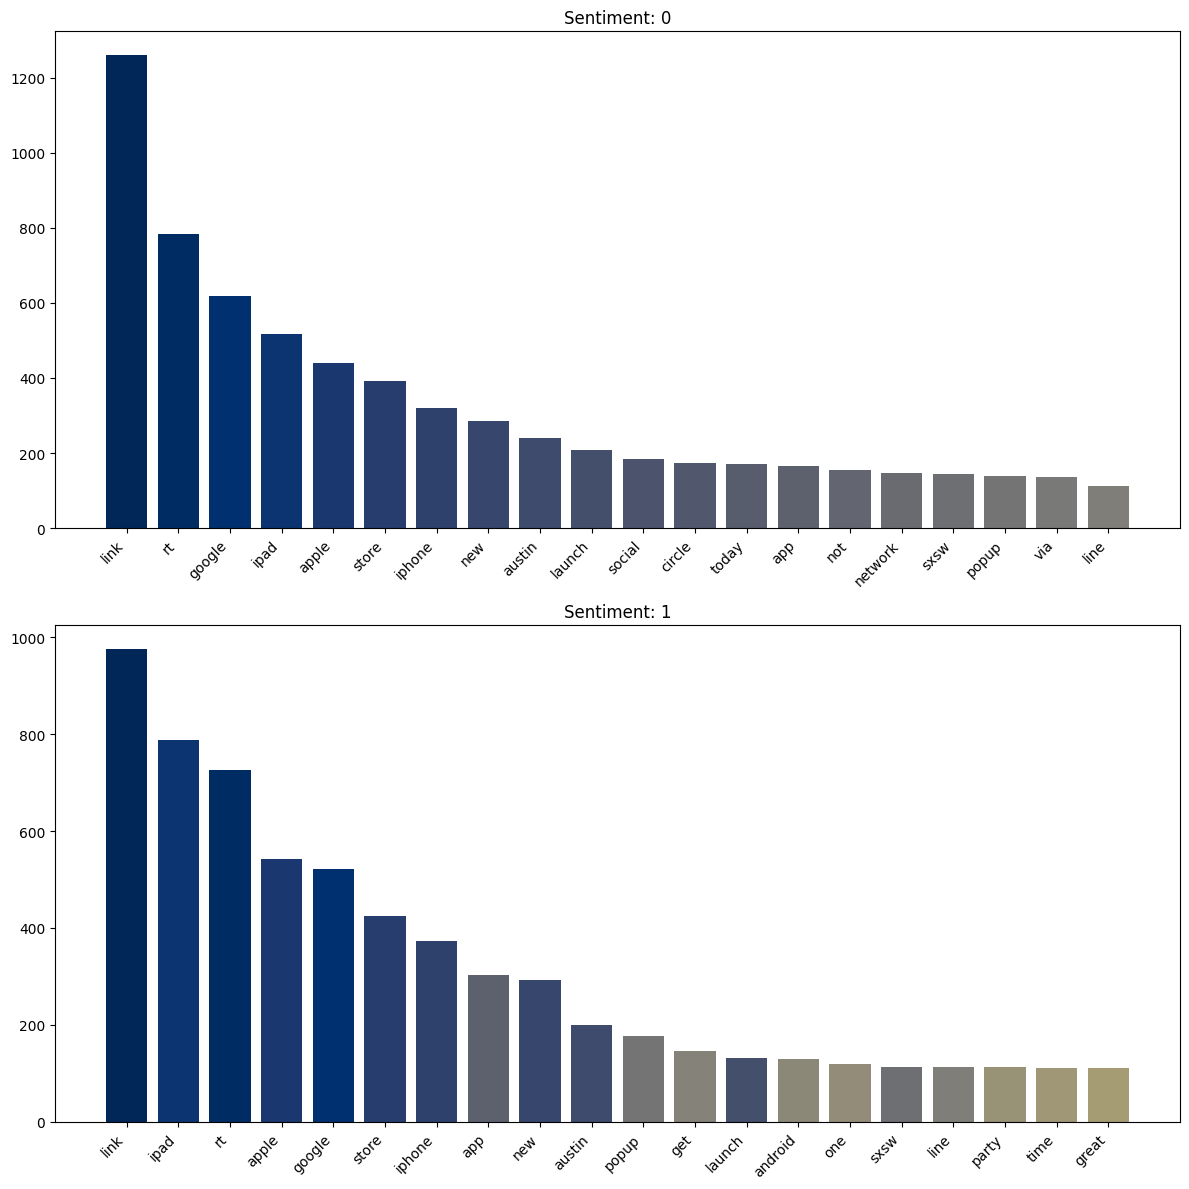

In [157]:
#check out the word distrobutions in X_train for each target class

from collections import Counter

color_palette = sns.color_palette('cividis', n_colors=38)

fig, axes = plt.subplots(nrows=2, figsize=(12, 12)) 

plotted_words_and_colors = {}

sentiment_classes = y_train.unique() 
for i, sentiment_class in enumerate(sentiment_classes):
    sentiment_data = X_train_resampled_tokens[y_train_resampled == sentiment_class]
    all_words_in_sentiment = [word for tokens in sentiment_data for word in tokens]
    top_10 = Counter(all_words_in_sentiment).most_common(20)
    
    colors = []
    
    for word, _ in top_10:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    ax = axes[i]
    words, counts = zip(*top_10)
    ax.bar(words, counts, color=colors)
    ax.set_title(f'Sentiment: {sentiment_class}') 
    ax.set_xticklabels(words, rotation=45, ha='right')

fig.tight_layout() 
plt.show()

In [60]:
# Join token lists into strings
X_train_str = X_train.apply(' '.join)
X_val_str = X_val.apply(' '.join)
X_test_str = X_test.apply(' '.join)

In [70]:
len(X_train_str)

7131

In [49]:
vector= TfidfVectorizer(max_features= 2000, ngram_range= (1,1), min_df= 0.0, max_df= 1.0)
vector.fit(X_train_str)

TfidfVectorizer(max_features=2000, min_df=0.0)

In [50]:
list(vector.get_feature_names_out())

['aapl',
 'ab',
 'abc',
 'able',
 'absolutely',
 'abt',
 'acc',
 'access',
 'accessibility',
 'accessory',
 'according',
 'account',
 'accuracy',
 'aclu',
 'acoustic',
 'acquired',
 'across',
 'action',
 'activity',
 'actsofsharingcom',
 'actually',
 'ad',
 'add',
 'added',
 'adoption',
 'advertising',
 'advice',
 'afar',
 'afford',
 'afternoon',
 'agchat',
 'age',
 'agency',
 'agileagency',
 'agnerd',
 'ago',
 'agree',
 'ahead',
 'air',
 'airport',
 'aka',
 'alarm',
 'album',
 'alert',
 'alive',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'alternate',
 'always',
 'amazing',
 'amazon',
 'america',
 'american',
 'americaquot',
 'among',
 'amount',
 'analytics',
 'anatomy',
 'andipad',
 'andoid',
 'android',
 'androidsxsw',
 'angrybirds',
 'announce',
 'announced',
 'announcement',
 'announces',
 'announcing',
 'annoying',
 'another',
 'answer',
 'answering',
 'anybody',
 'anymore',
 'anyone',
 'anything',
 'anywhere',
 'api',
 'apis',
 'app',
 'apparently',
 'appearance',
 'app

In [86]:
vector= TfidfVectorizer(max_features= 2000, ngram_range= (1,1), min_df= .001, max_df= 1.0)
vector.fit(X_train_str.tolist())
list(vector.get_feature_names_out())

['ab',
 'able',
 'abt',
 'acc',
 'access',
 'accessibility',
 'account',
 'aclu',
 'across',
 'action',
 'actsofsharingcom',
 'actually',
 'ad',
 'add',
 'added',
 'adoption',
 'advice',
 'afford',
 'agchat',
 'agency',
 'agileagency',
 'ago',
 'agree',
 'ahead',
 'air',
 'airport',
 'alarm',
 'album',
 'almost',
 'already',
 'also',
 'always',
 'amazing',
 'america',
 'americaquot',
 'among',
 'analytics',
 'andoid',
 'android',
 'announce',
 'announced',
 'announcement',
 'announces',
 'another',
 'answer',
 'anybody',
 'anyone',
 'anything',
 'anywhere',
 'api',
 'app',
 'apparently',
 'appears',
 'apple',
 'apps',
 'around',
 'arrived',
 'art',
 'article',
 'artist',
 'as',
 'ask',
 'asked',
 'atandt',
 'att',
 'attend',
 'attendance',
 'attendee',
 'attending',
 'atx',
 'au',
 'audience',
 'augmented',
 'austin',
 'autocorrect',
 'available',
 'award',
 'away',
 'awesome',
 'baby',
 'back',
 'bad',
 'badge',
 'bag',
 'ballroom',
 'band',
 'bank',
 'bar',
 'barry',
 'barton',
 'bas

In [77]:
X_train_str[0]

'wesley g iphone hr tweeting rise austin dead need upgrade plugin station sxsw'

In [23]:
pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=24, 
                               C=1,
                               class_weight=None,
                               fit_intercept=True,
                               solver='saga',
                               tol=0.0001))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [2000],
    'tfidf__ngram_range': [(1, 1)],
    'tfidf__min_df': [0.0],
    'tfidf__max_df': [1.0]}

#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

grid_search1.fit(X_train_str, y_train)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'tfidf__max_df': 1.0, 'tfidf__max_features': 2000, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 1)}
Best Train Cross-Validation Score: 0.7225
Validation Set Accuracy: 0.7542


In [24]:
X_list_1= X_train_str[:100]

In [25]:
pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=24, 
                               C=1,
                               class_weight=None,
                               fit_intercept=True,
                               solver='saga',
                               tol=0.0001))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [3000],
    'tfidf__ngram_range': [(1, 2)],
    'tfidf__min_df': [0.2],
    'tfidf__max_df': [0.8]}

#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

grid_search1.fit(X_train_str, y_train)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'tfidf__max_df': 0.8, 'tfidf__max_features': 3000, 'tfidf__min_df': 0.2, 'tfidf__ngram_range': (1, 2)}
Best Train Cross-Validation Score: 0.6669
Validation Set Accuracy: 0.6745


In [27]:
X_list_2= X_train_str[:100]

In [31]:
X_list_2[:100]

7595                    google circle happening lost sxsw
2916    apple opening popup shop downtown austin sxsw ...
4121       cool apple open temporary store sxsw link sxsw
8303    cant wait see internet implode austin friday e...
8165    lifter link google league extraordinary hckers...
                              ...                        
6603    rt mention rt mention rt mention google launch...
8136    great sxsw session google marissa mayer local ...
959     technews omg jk kiss ipad slap xoom link tech ...
8865    sxsw crowd austin swarm ipad launch link via m...
8268    huge shout gsdm google kick as party tonight u...
Name: tweet_lem, Length: 100, dtype: object

In [32]:
X_list_1[:100]

7595                    google circle happening lost sxsw
2916    apple opening popup shop downtown austin sxsw ...
4121       cool apple open temporary store sxsw link sxsw
8303    cant wait see internet implode austin friday e...
8165    lifter link google league extraordinary hckers...
                              ...                        
6603    rt mention rt mention rt mention google launch...
8136    great sxsw session google marissa mayer local ...
959     technews omg jk kiss ipad slap xoom link tech ...
8865    sxsw crowd austin swarm ipad launch link via m...
8268    huge shout gsdm google kick as party tonight u...
Name: tweet_lem, Length: 100, dtype: object